In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import mode, gamma
from scipy.special import expit, logit

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def precision_and_recall(df, true_col="release", pred_col="release_pred"):
    true_positives = len(df[(df[true_col] == 1) & (df[pred_col] == 1)])
    false_positives = len(df[(df[true_col] != 1) & (df[pred_col] == 1)])
    false_negatives = len(df[(df[true_col] == 1) & (df[pred_col] != 1)])

    return (np.round(true_positives / (true_positives + false_positives), 3),
            np.round(true_positives / (true_positives + false_negatives), 3))

## Load Training and Testing Data

In [8]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2500, testing examples = 325


In [9]:
df.columns

Index(['index', 'days_since_previous_release', 'release',
       'days_until_next_release', 'month_holidays', 'weekday', 'year',
       'WD_Monday', 'WD_Saturday', 'WD_Sunday', 'WD_Thursday', 'WD_Tuesday',
       'WD_Wednesday', 'previous_release'],
      dtype='object')

In [10]:
weekday_in_year_id = {tuple(pair) : i for (i, pair) in enumerate(df[["weekday", "year"]].drop_duplicates().values)}
df["weekday_in_year_id"] = df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)
train_df["weekday_in_year_id"] = train_df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)
test_df["weekday_in_year_id"] = test_df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)

In [11]:
days_between_id = {tuple(pair) : i for (i, pair) in enumerate(
    df[["days_since_previous_release", "previous_release"]].drop_duplicates().values)}
df["days_between_id"] = df.apply(lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release"])], axis=1)
train_df["days_between_id"] = train_df.apply(
    lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release"])], axis=1)
test_df["days_between_id"] = test_df.apply(
    lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release"])], axis=1)

## Model-Building and Evaluation

In [12]:
train_df = pandas.concat([train_df[train_df["release"] == 1], train_df.query('release == 0 & year >= 2022')],
                         ignore_index=True).sort_values(by=["index"])

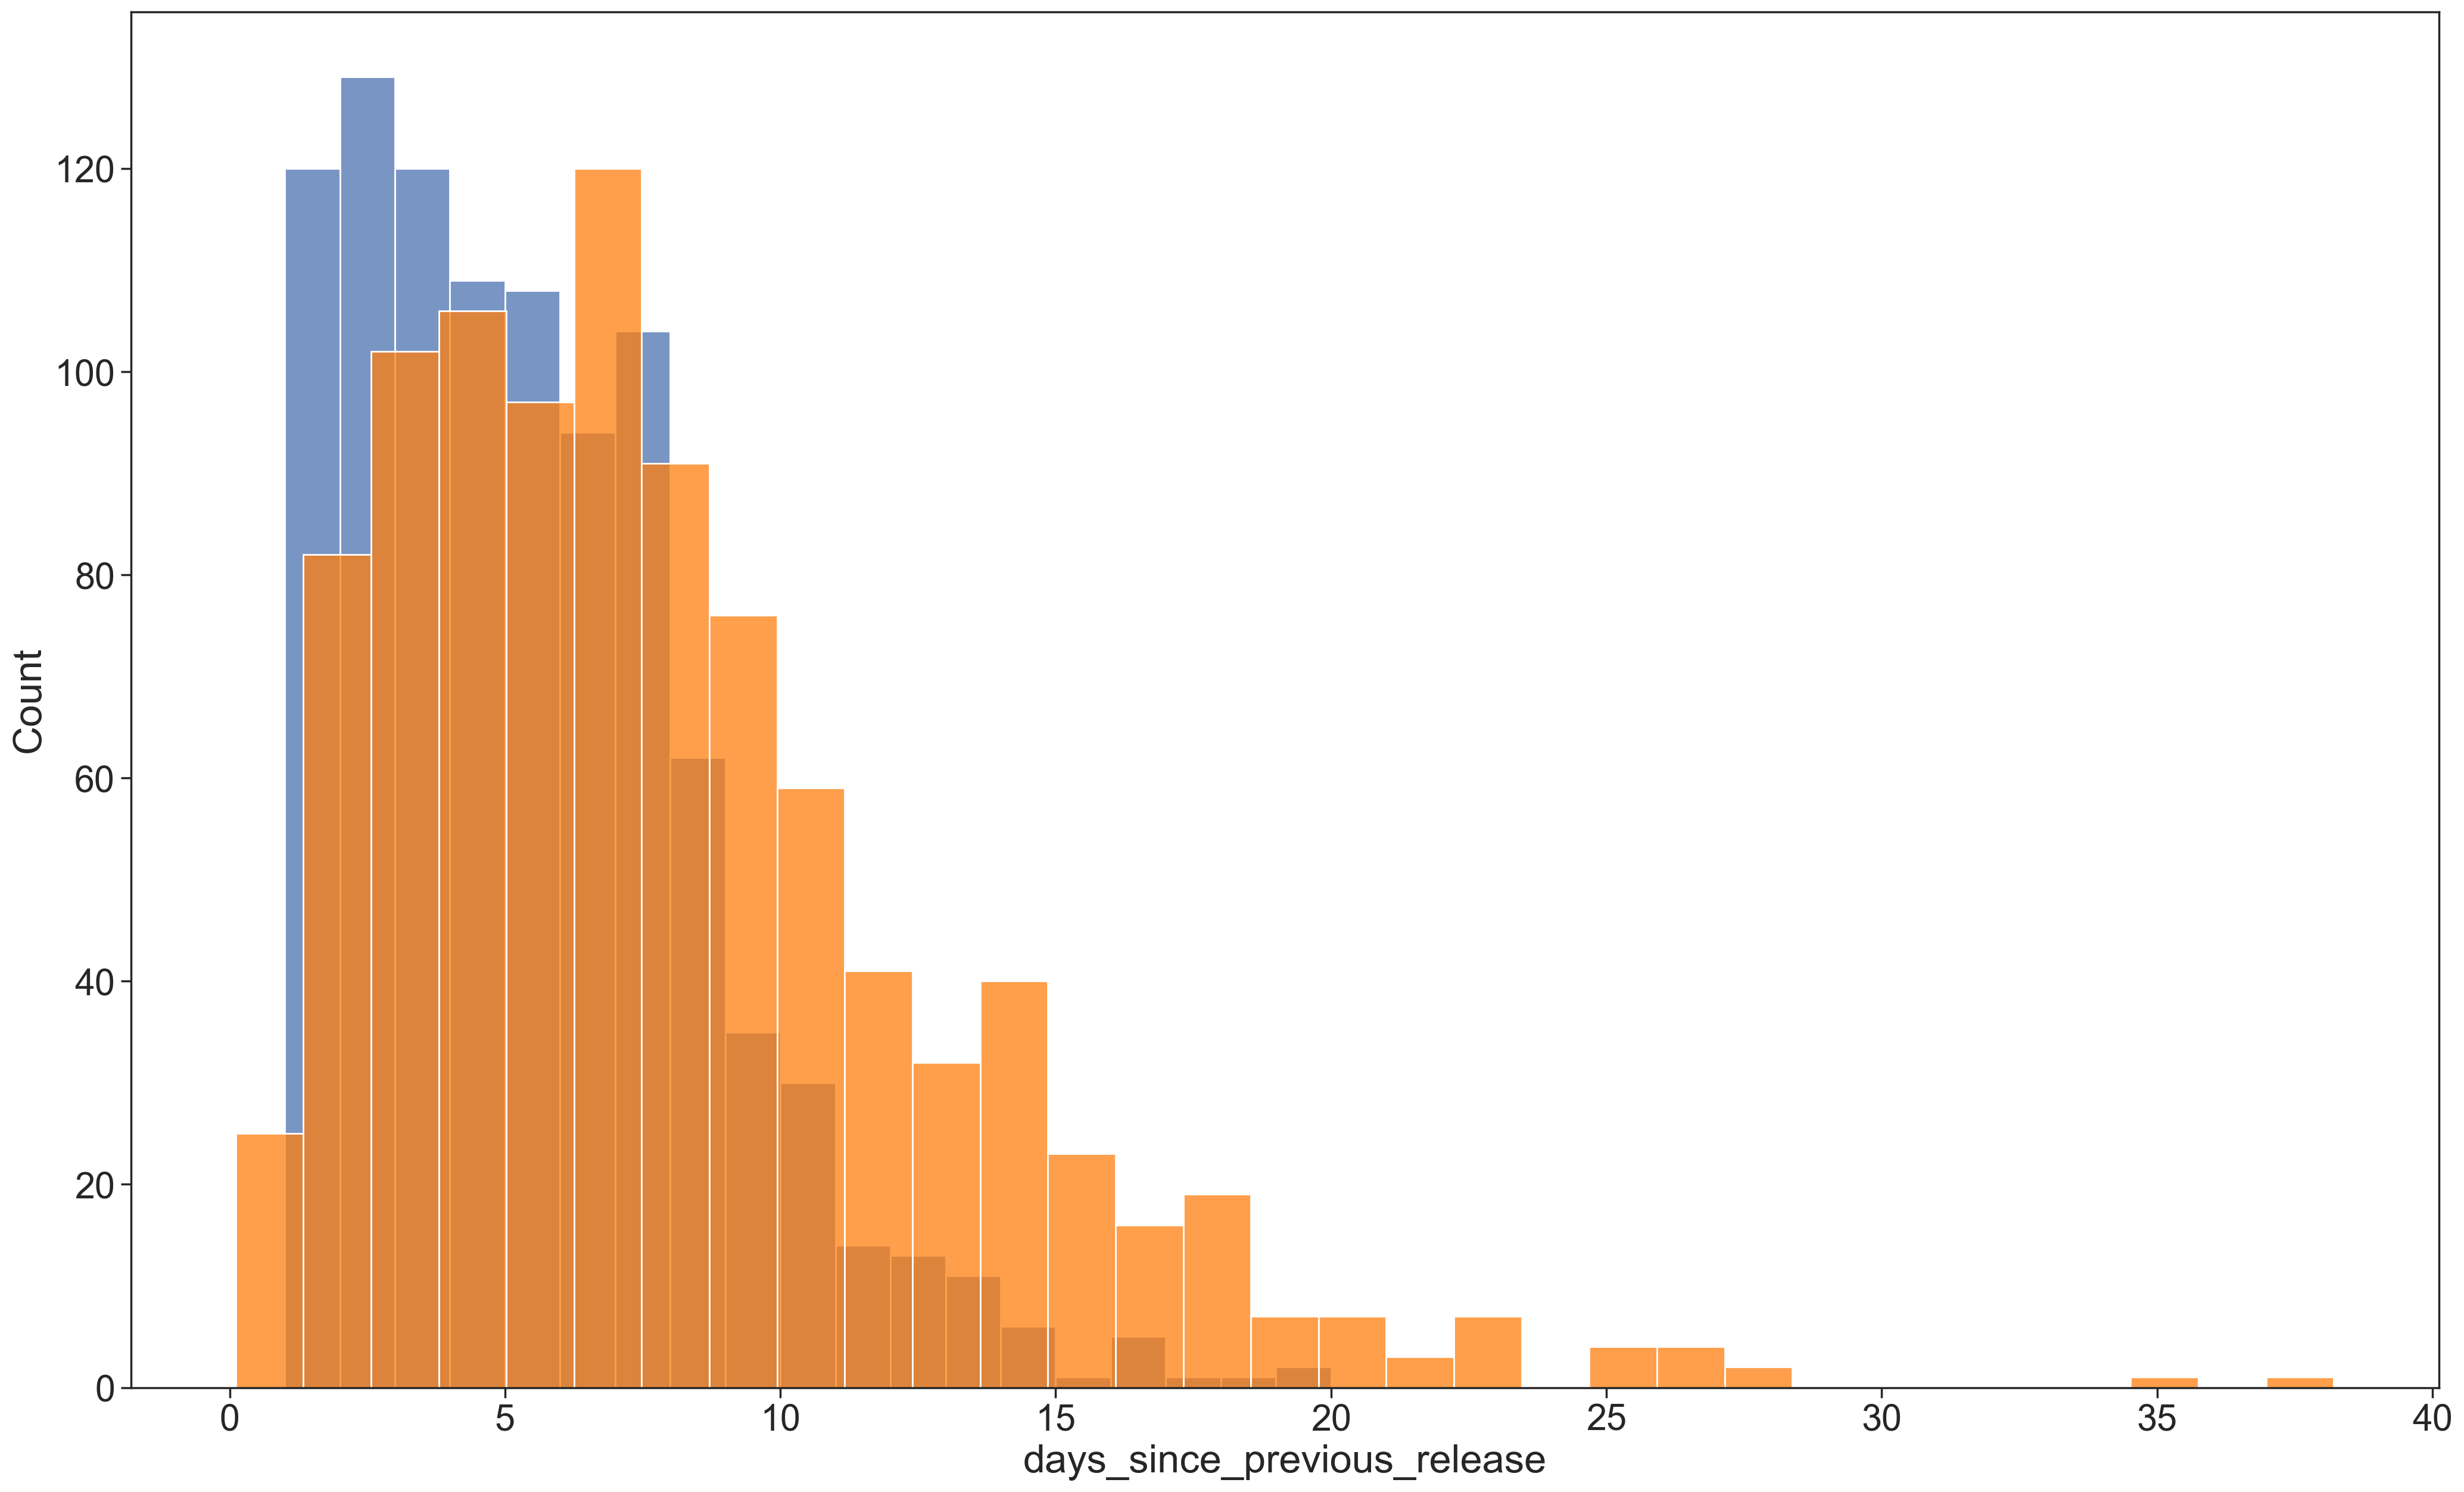

In [13]:
ax = sns.histplot(x=train_df["days_since_previous_release"])

alpha = (train_df["days_since_previous_release"].mean() ** 2) / (train_df["days_since_previous_release"].std(ddof=1) ** 2)

sns.histplot(x=gamma.rvs(alpha, scale=train_df["days_since_previous_release"].std(ddof=1), size=len(train_df)),
             ax=ax, color="tab:orange")

plt.show()

In [14]:
train_df = train_df.set_index("index")
(obs_id, _) = train_df.index.factorize()

In [15]:
weekday_in_year_id = train_df["weekday_in_year_id"].values
days_between_id = train_df["days_between_id"].values

In [16]:
COORDS = {
    "weekday_in_year" : weekday_in_year_id,
    "days_between_id" : days_between_id,
    "observation" : obs_id,
}

In [17]:
m = train_df["days_since_previous_release"].mean()
s = train_df["days_since_previous_release"].std(ddof=1)
(m, s)

(4.998963730569948, 3.1960490007958486)

In [18]:
with pm.Model(coords=COORDS) as model:
    weekday_in_year_effect = pm.Normal("weekday_in_year_effect", 0, 1, dims="weekday_in_year")
    sigma_mu = pm.HalfNormal("sigma_mu", 1)
    days_between_effect = pm.GaussianRandomWalk("days_between_effect",
                                                sigma=sigma_mu,
                                                init_dist=pm.Gamma.dist("mu", mu=m, sigma=s),
                                                dims="days_between_id")

    release_prob = pm.math.invlogit(
        days_between_effect[days_between_id] + weekday_in_year_effect[weekday_in_year_id]
    )

    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=train_df["release"].values,
        dims="observation",
    )

In [19]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekday_in_year_effect, sigma_mu, days_between_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### In-Sample Evaluation

In [21]:
with model:
    pred = pm.sample_posterior_predictive(idata, predictions=True, var_names=["release"])

Sampling: [release]


Output()

In [22]:
train_df["release_pred"] = [mode(p)[0] for p in pred["predictions"]["release"].stack(all_draws=["chain", "draw"]).values]

In [23]:
train_df["release_pred"].value_counts()

release_pred
0    671
1    294
Name: count, dtype: int64

In [24]:
train_df["release"].value_counts()

release
0    615
1    350
Name: count, dtype: Int64

<Axes: ylabel='Count'>

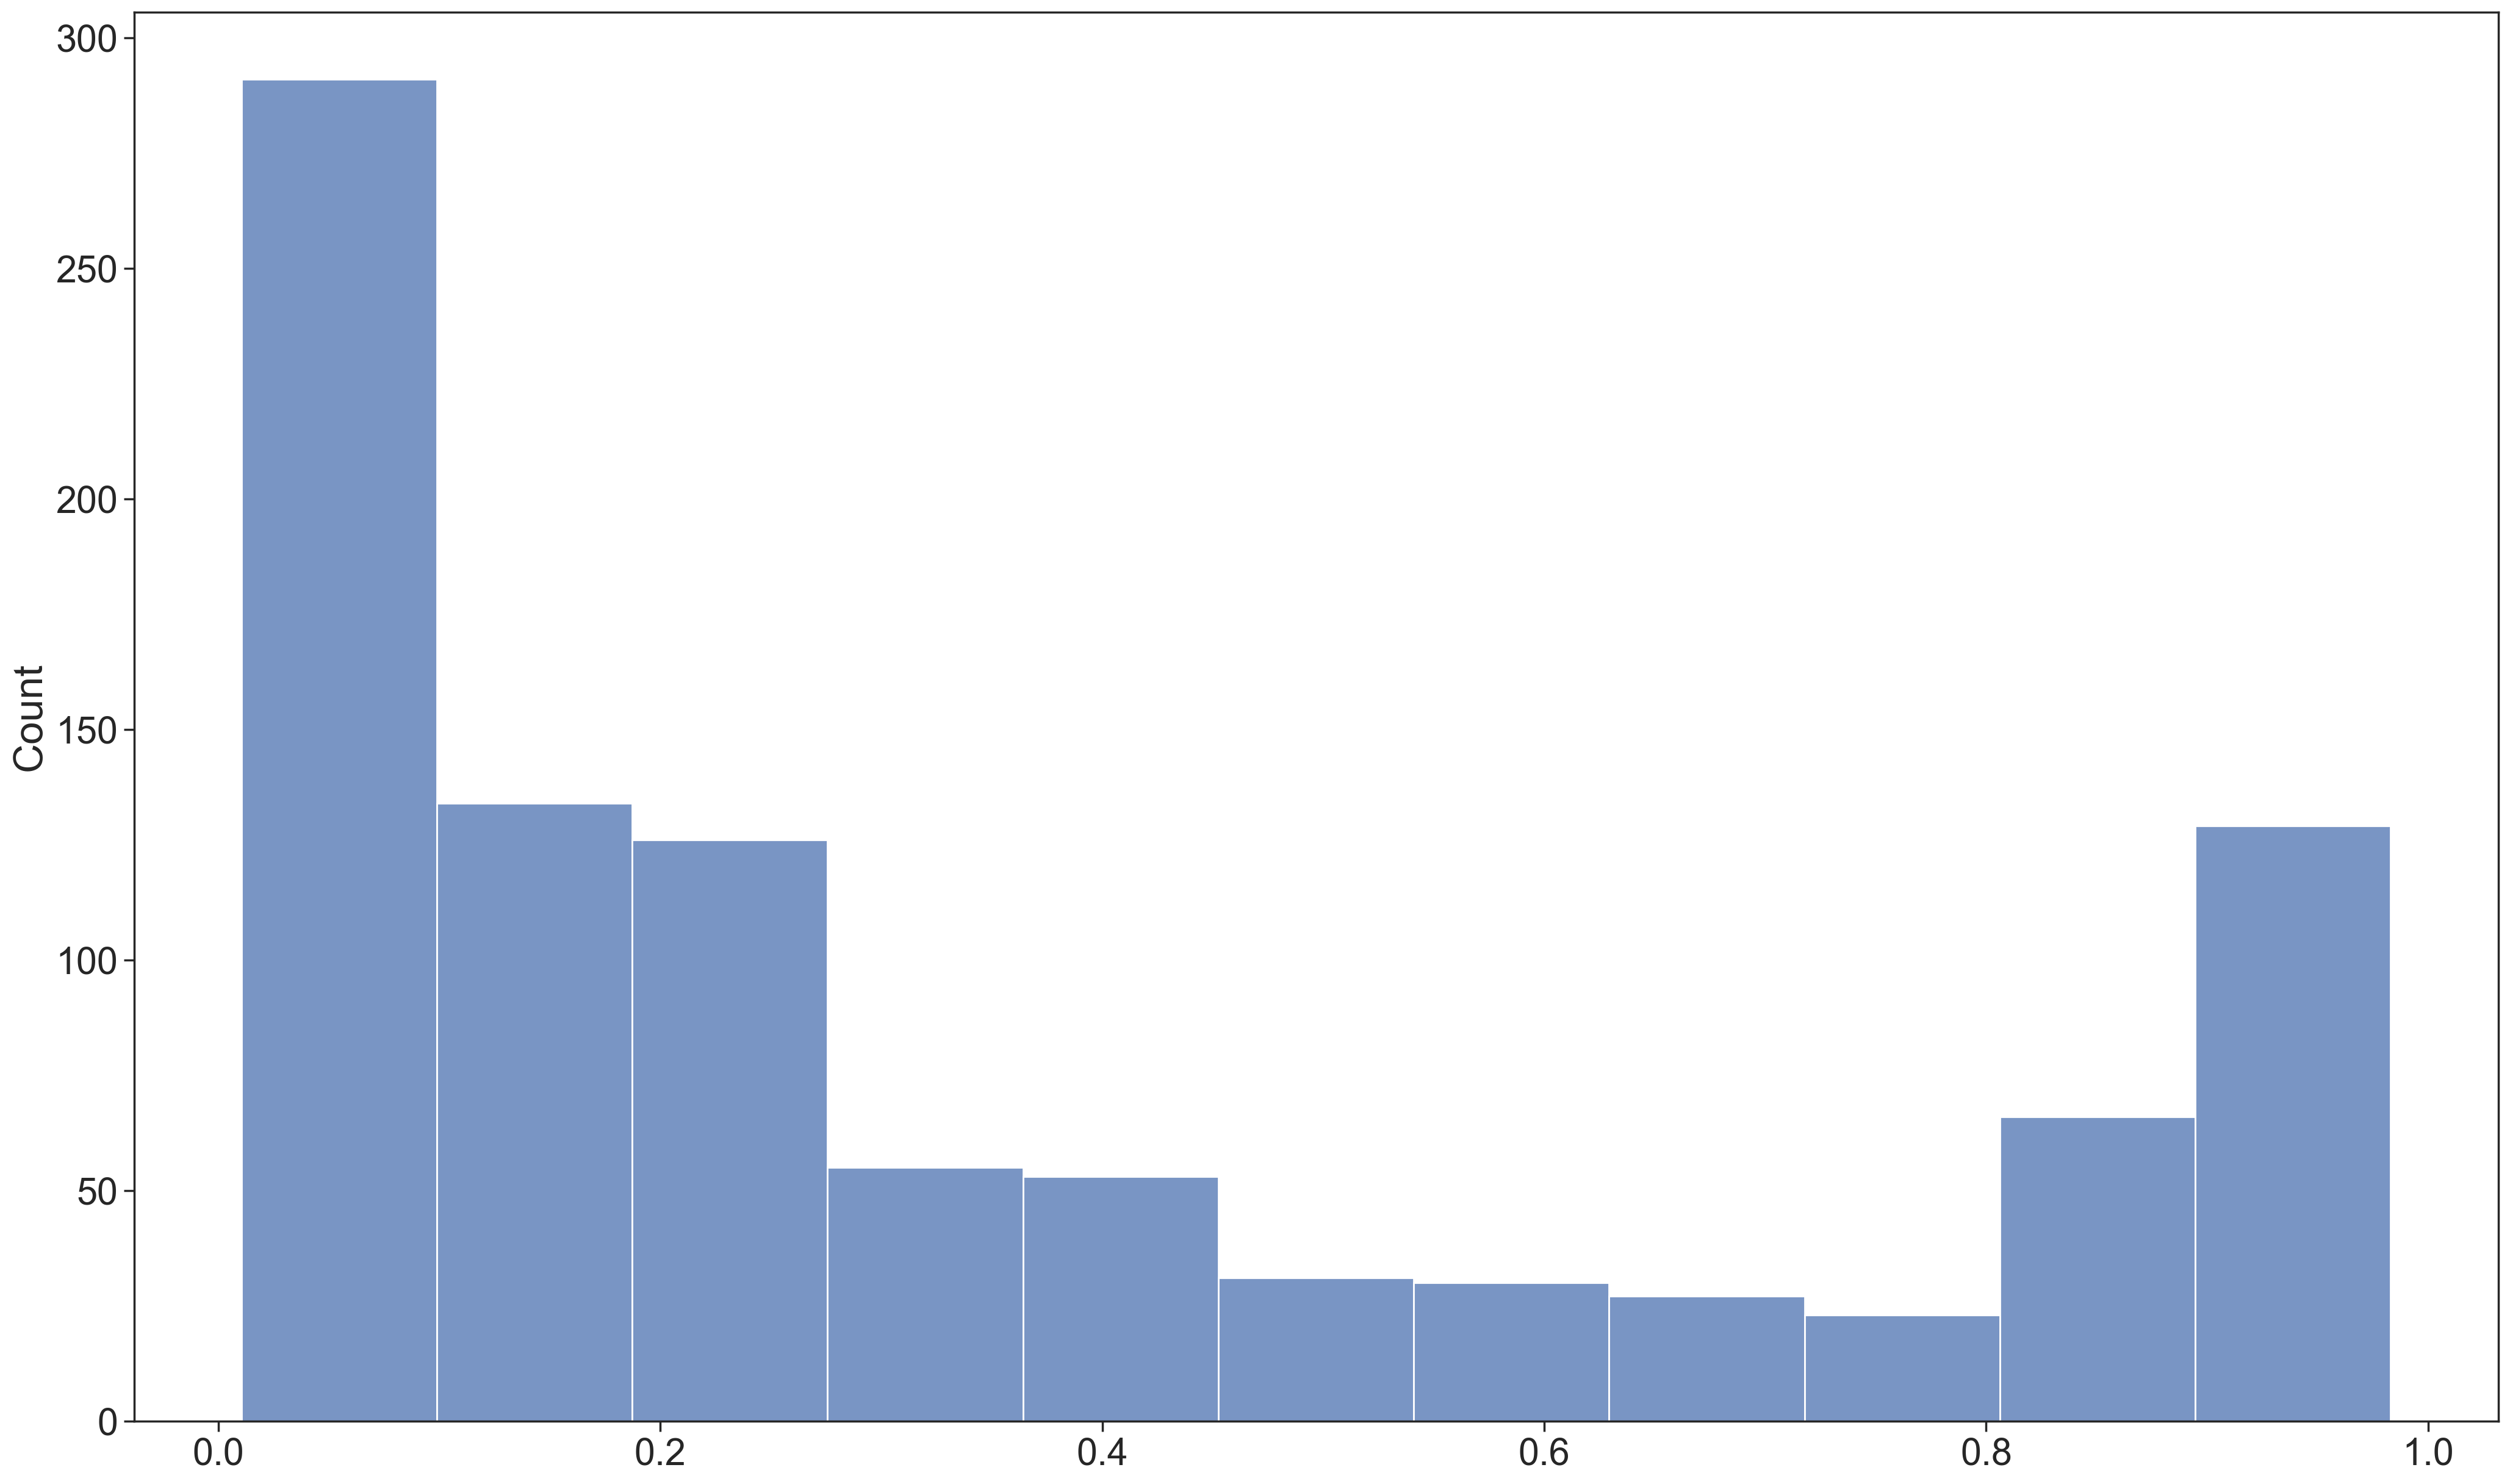

In [25]:
sns.histplot(x=np.mean(pred["predictions"]["release"].stack(all_draws=["chain", "draw"]).values, axis=1))

In [26]:
precision_and_recall(train_df)

(0.915, 0.769)

### Out-of-Sample Evaluation

In [28]:
# resources
# https://discourse.pymc.io/t/sample-posterior-predicitve-not-catching-shape-of-new-data/10179/10
# https://alexandorra.github.io/pollsposition_blog/popularity/macron/hidden%20markov%20models/polls/2021/05/16/hmm-popularity.html#Posterior-predictions
# https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/
# https://gist.github.com/jonsedar/24f1c285a32e873da711caef92147feb
# https://github.com/junpenglao/Bayesian_Smoothing_EyeMovement/blob/master/Bayesian_Smoothing.ipynb

# this is like to augment the model "training" data
# https://discourse.pymc.io/t/making-out-of-sample-predictions-with-gaussianrandomwalk/9703

In [89]:
# test_df = test_df.set_index("index")
(test_obs_id, _) = test_df.index.factorize()

In [90]:
test_days_between_id = test_df["days_between_id"].values
test_weekday_in_year = test_df["weekday_in_year_id"].values

In [91]:
TEST_COORDS = {
    "test_weekday_in_year" : test_weekday_in_year,
    "test_days_between_id" : test_days_between_id,
    "test_observation" : test_obs_id + (max(obs_id) + 1)
}

In [79]:
# m = test_df["days_since_previous_release"].mean()
# s = test_df["days_since_previous_release"].std(ddof=1)
# (m, s)

In [106]:
'''
    weekday_in_year_effect = pm.Normal("weekday_in_year_effect", 0, 1, dims="weekday_in_year")
    sigma_mu = pm.HalfNormal("sigma_mu", 1)
    days_between_effect = pm.GaussianRandomWalk("days_between_effect",
                                                sigma=sigma_mu,
                                                init_dist=pm.Gamma.dist(mu=m, sigma=s),
                                                dims="days_between_id")

    release_prob = pm.math.invlogit(
        days_between_effect[days_between_id] + weekday_in_year_effect[weekday_in_year_id]
    )

    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=train_df["release"].values,
        dims="observation",
    )
'''



# Add variables to the model to get the forecast and predictions
with model:
    model.add_coords(TEST_COORDS)
    # future_weekday_const = pm.Data("test_weekday_in_year", test_weekday_in_year, dims="test_observation")
    future_weekday_in_year = pm.Normal("test_weekday_in_year_effect", 0, 1, dims="test_observation")

    # future_days_between_effect = pm.GaussianRandomWalk("test_days_between_effect",
    #                                                    sigma=sigma_mu,
    #                                                    init_dist=pm.Gamma.dist(mu=days_between_effect,
    #                                                                            sigma=sigma_mu),
    #                                                    dims="test_observation")

    # mdl.add_coords({'obs_id_fut': idx_hold})
    # x_fut = pm.Data('x_fut', df.loc[idx_hold, 'waiting'].values, dims='obs_id_fut')
    # y_fut = pm.Data('y_fut', df.loc[idx_hold, 'eruptions'].values, dims='obs_id_fut')
    
    # b1_fut = pm.GaussianRandomWalk(
    #                 'b1_fut', 
    #                 init=pm.Normal.dist(mu=b1[-1] + b1_mu, sigma=b1_s), 
    #                 mu=b1_mu, 
    #                 sigma=b1_s,
    #                 dims='obs_id_fut'
    #             )
    
    # lm_fut= b0 + b1_fut * x_fut

    # yhat_fut = pm.Normal('yhat_fut', mu=lm_fut, sigma=yhat_s, observed=y_fut, dims='obs_id_fut')


In [107]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekday_in_year_effect, sigma_mu, days_between_effect, test_weekday_in_year_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [108]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data